In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from config import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import csv
import os
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import importlib
from torchsummary import summary
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler
import gc
from multiprocessing import Pool, set_start_method
from matplotlib.path import Path
import open3d as o3d
import matplotlib.pyplot as plt
import cv2
import pickle
from datetime import datetime
import random
import math
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def load_points_grid_map(csv_file):
    """Load bounding box vertices from a CSV file."""
    points = np.loadtxt(csv_file, delimiter=',', usecols=(0, 1, 2), dtype=float)
    return points

def load_points_grid_map_BB (csv_file):
    """Load bounding box vertices from a CSV file."""
    points = []
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        
        for row in reader:
            # Extract the 3D coordinates of the 8 bounding box vertices
            coordinates = [ [ float(row[i]), float(row[i+1]), float(row[i+2]) ] for i in range(2, 12, 3)]
            points.append(coordinates)

    np_points = np.array(points)
    return np_points

def generate_combined_grid_maps(grid_map_path, grid_map_BB_path, complete_grid_maps, complete_grid_maps_BB, complete_num_BB):
    grid_map_files = sorted([f for f in os.listdir(grid_map_path)])
    grid_map_BB_files = sorted([f for f in os.listdir(grid_map_BB_path)])
    
    for file, file_BB in zip(grid_map_files, grid_map_BB_files):
        # Import constants inside the function
        complete_path = os.path.join(grid_map_path, file)
        complete_path_BB = os.path.join(grid_map_BB_path, file_BB)
        print(f"Loading {file} and {file_BB}...")

        points_BB = load_points_grid_map_BB(complete_path_BB)

        num_BB = [0,0,0]
        with open(complete_path_BB, 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            for row in reader:
                if row[1] == 'pedestrian':
                    num_BB[0] += 1
                elif row[1] == 'bicycle':
                    num_BB[1] += 1
                elif row[1] == 'car':
                    num_BB[2] += 1
        
        points = load_points_grid_map(complete_path)

        grid_map_recreate = np.full((Y_RANGE, X_RANGE), FLOOR_HEIGHT, dtype=float)
        grid_map_recreate_BB = np.full((Y_RANGE, X_RANGE), 0, dtype=float)

        cols, rows, heights = points.T
        grid_map_recreate[rows.astype(int), cols.astype(int)] = heights.astype(int)


        for i in range(len(points_BB)):
            vertices = np.array(points_BB[i])
            height_BB = 1  # Assuming all vertices have the same height
            fill_polygon(grid_map_recreate_BB, vertices, height_BB)

        complete_grid_maps.append(grid_map_recreate)
        complete_grid_maps_BB.append(grid_map_recreate_BB)
        complete_num_BB.append(num_BB)

def fill_polygon(grid_map, vertices, height):
    # Create an empty mask with the same shape as the grid map
    mask = np.zeros_like(grid_map, dtype=np.uint8)
    
    # Convert vertices to integer coordinates
    vertices_int = np.array(vertices[:, :2], dtype=np.int32)
    
    # Define different orders to try
    orders = [
        [0, 1, 3, 2],
        [0, 1, 2, 3],
    ]
    
    # Try filling the polygon with different orders of vertices
    for order in orders:
        ordered_vertices = vertices_int[order]
        cv2.fillPoly(mask, [ordered_vertices], 1)
    
    # Set the height for the filled area in the grid map
    grid_map[mask == 1] = height

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)

def visualize_prediction(prediction, real):
    """
    Visualize the grid map and the prediction.
    
    Parameters:
    - grid_map: numpy array of shape (400, 400)
    - prediction: numpy array of shape (400, 400)
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(prediction, cmap='gray')
    ax[0].set_title('Prediction Map')
    
    ax[1].imshow(real, cmap='gray')
    ax[1].set_title('Real Map')
    
    plt.show()

def split_data(lidar_data, BB_data, num_BB, size):
    # Split the dataset into a combined training and validation set, and a separate test set using num_BB as stratification

    X_train_val, X_test, y_train_val, y_test, num_BB_train_val, num_BB_test = train_test_split(
        lidar_data, # Samples
        BB_data, # Labels
        num_BB, # Number of BB
        test_size = size,
        random_state=SEED, # type: ignore
        stratify=num_BB
    )
    return X_train_val, X_test, y_train_val, y_test, num_BB_train_val, num_BB_test

def visualize_proportion(data):
    sum = 0
    for i in range(len(data)):
        sum += data[i]
    return sum

In [3]:
if __name__ == "__main__":
    
    gc.collect()

    set_start_method("spawn", force=True)

    random.seed(SEED)
    print("SEED:", random.seed())

    # Load scalers
    with open(os.path.join(SCALER_DIR, 'scaler_X.pkl'), 'rb') as f:
        scaler_X = pickle.load(f)
    with open(os.path.join(SCALER_DIR, 'scaler_y.pkl'), 'rb') as f:
        scaler_y = pickle.load(f)
    

SEED: None


In [4]:
# Shuffle files_lidar_1 and files_BB_1 in the same way
combined_files = list(zip(sorted([f for f in os.listdir(LIDAR_1_GRID_DIRECTORY)]), sorted([f for f in os.listdir(POSITION_LIDAR_1_GRID_NO_BB)])))
random.shuffle(combined_files)
files_lidar_1, files_BB_1 = zip(*combined_files)
# Convert back to lists if needed
files_lidar_1 = list(files_lidar_1)
files_BB_1 = list(files_BB_1)

combined_files = list(zip(sorted([f for f in os.listdir(LIDAR_2_GRID_DIRECTORY)]), sorted([f for f in os.listdir(POSITION_LIDAR_2_GRID_NO_BB)])))
random.shuffle(combined_files)
files_lidar_2, files_BB_2 = zip(*combined_files)
# Convert back to lists if needed
files_lidar_2 = list(files_lidar_2)
files_BB_2 = list(files_BB_2)

combined_files = list(zip(sorted([f for f in os.listdir(LIDAR_3_GRID_DIRECTORY)]), sorted([f for f in os.listdir(POSITION_LIDAR_3_GRID_NO_BB)])))
random.shuffle(combined_files)
files_lidar_3, files_BB_3 = zip(*combined_files)
# Convert back to lists if needed
files_lidar_3 = list(files_lidar_3)
files_BB_3 = list(files_BB_3)

In [5]:
complete_grid_maps = []
complete_grid_maps_BB = []
complete_num_BB = []

generate_combined_grid_maps(LIDAR_1_GRID_DIRECTORY, POSITION_LIDAR_1_GRID_NO_BB, complete_grid_maps, complete_grid_maps_BB, complete_num_BB) # type: ignore
generate_combined_grid_maps(LIDAR_2_GRID_DIRECTORY, POSITION_LIDAR_2_GRID_NO_BB, complete_grid_maps, complete_grid_maps_BB, complete_num_BB) # type: ignore
generate_combined_grid_maps(LIDAR_3_GRID_DIRECTORY, POSITION_LIDAR_3_GRID_NO_BB, complete_grid_maps, complete_grid_maps_BB, complete_num_BB) # type: ignore

Loading 20250305_164842_869755_0.csv and 20250305_164842_864245_0.csv...
Loading 20250305_164842_897794_1.csv and 20250305_164842_890295_1.csv...
Loading 20250305_164842_938864_2.csv and 20250305_164842_942862_2.csv...
Loading 20250305_164842_971280_3.csv and 20250305_164842_974281_3.csv...
Loading 20250305_164843_016814_4.csv and 20250305_164843_021325_4.csv...
Loading 20250305_164843_065124_5.csv and 20250305_164843_067630_5.csv...
Loading 20250305_164843_095158_6.csv and 20250305_164843_098667_6.csv...
Loading 20250305_164843_158220_7.csv and 20250305_164843_161224_7.csv...
Loading 20250305_164843_185848_8.csv and 20250305_164843_193449_8.csv...
Loading 20250305_164843_251991_9.csv and 20250305_164843_254947_9.csv...
Loading 20250305_164843_278985_10.csv and 20250305_164843_271656_10.csv...
Loading 20250305_164843_345264_11.csv and 20250305_164843_348819_11.csv...
Loading 20250305_164843_373027_12.csv and 20250305_164843_381214_12.csv...
Loading 20250305_164843_438680_13.csv and 202

In [6]:
print(len(complete_grid_maps))

3043


In [7]:
# Concatenate the lists in complete_grid_maps along the first dimension
complete_grid_maps = np.array(complete_grid_maps)
print(f"complete grid map shape : {complete_grid_maps.shape}")

# Concatenate the lists in complete_grid_maps_BB along the first dimension
complete_grid_maps_BB = np.array(complete_grid_maps_BB)
print(f"complete grid map BB shape : {complete_grid_maps_BB.shape}")

complete_grid_maps = scaler_X.transform(complete_grid_maps.reshape(-1, complete_grid_maps.shape[-1])).reshape(complete_grid_maps.shape)
complete_grid_maps_BB = scaler_y.transform(complete_grid_maps_BB.reshape(-1, complete_grid_maps_BB.shape[-1])).reshape(complete_grid_maps_BB.shape)

# Shuffle the data
combined_files = list(zip(complete_grid_maps, complete_grid_maps_BB, complete_num_BB))
random.shuffle(combined_files)
complete_grid_maps, complete_grid_maps_BB, complete_numb_BB = zip(*combined_files)
# Convert back to lists if needed
complete_grid_maps = np.array(complete_grid_maps)
complete_grid_maps_BB = np.array(complete_grid_maps_BB)
complete_numb_BB = list(complete_numb_BB)

complete grid map shape : (3043, 400, 400)
complete grid map BB shape : (3043, 400, 400)


In [8]:
print("point BB original:", complete_grid_maps_BB[0][0][0], complete_grid_maps_BB[0][399][0], complete_grid_maps_BB[0][0][399], complete_grid_maps_BB[0][399][399])
print("point original:", complete_grid_maps[0][0][0], complete_grid_maps[0][399][0], complete_grid_maps[0][0][399], complete_grid_maps[0][399][399])


point BB original: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0


In [9]:
import cv2
import numpy as np

def rotate_image(image, angle):
    if image is None or image.size == 0:
        raise ValueError("Invalid image provided for rotation.")
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return rotated

def slide_horizontal(image, shift):
    """
    Slide the given image horizontally by the specified shift using OpenCV.

    Parameters:
    - image: numpy array to be shifted.
    - shift: The number of pixels to shift the image.

    Returns:
    - Shifted numpy array.
    """
    M = np.float32([[1, 0, shift], [0, 1, 0]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return shifted

def slide_vertical(image, shift):
    """
    Slide the given image vertically by the specified shift using OpenCV.

    Parameters:
    - image: numpy array to be shifted.
    - shift: The number of pixels to shift the image.

    Returns:
    - Shifted numpy array.
    """
    M = np.float32([[1, 0, 0], [0, 1, shift]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return shifted

def apply_augmentation(grid_maps, grid_maps_BB):

    augmentations = {
        'horizontal_flip': lambda img: cv2.flip(img, 1),
        'vertical_flip': lambda img: cv2.flip(img, 0),
        'rotation': rotate_image,
        'slide_horizontal': slide_horizontal,
        'slide_vertical': slide_vertical
    }

    augmented_grid_maps = []
    augmented_grid_maps_BB = []

    # Set the random seed for consistency
    random.seed(SEED)
    
    for i in range(grid_maps.shape[0]):
        grid_map = grid_maps[i]
        grid_map_BB = grid_maps_BB[i]
        
        applied_augmentations = set()
        for j in range(2):
            while True:
                # Seleziona casualmente un'augmentation
                augmentation_name, augmentation = random.choice(list(augmentations.items()))
                if augmentation_name not in applied_augmentations:
                    applied_augmentations.add(augmentation_name)
                    break

            # Applica la stessa augmentation a entrambe le immagini
            if augmentation_name == 'rotation':
                while True:
                    angle = random.randint(-45, 45)
                    if angle < -30 or angle > 30:
                        break
                grid_map = augmentation(grid_map, angle)
                grid_map_BB = augmentation(grid_map_BB, angle)

            elif augmentation_name in ['slide_horizontal', 'slide_vertical']:
                while True:
                    shift = random.randint(-100, 100)
                    if shift < -50 or shift > 50:
                        break
                grid_map = augmentation(grid_map, shift)
                grid_map_BB = augmentation(grid_map_BB, shift)
            else:
                grid_map = augmentation(grid_map)
                grid_map_BB = augmentation(grid_map_BB)
        
        augmented_grid_maps.append(grid_map)
        augmented_grid_maps_BB.append(grid_map_BB)
    
    return augmented_grid_maps, augmented_grid_maps_BB

Augmented grid map shape: (40, 400, 400)
Augmented grid map BB shape: (40, 400, 400)
point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


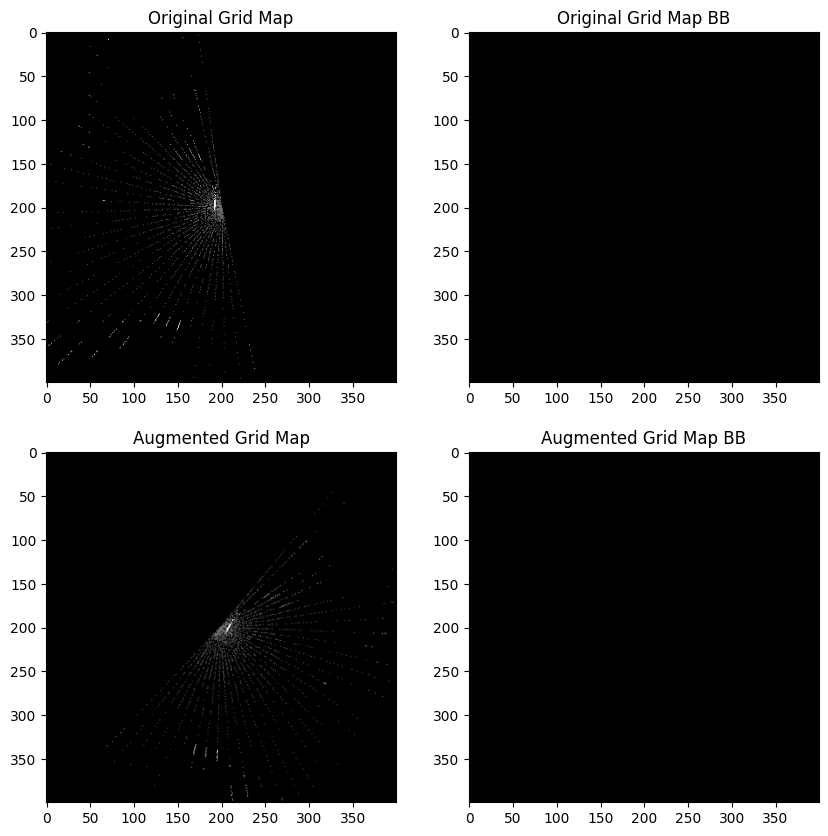

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


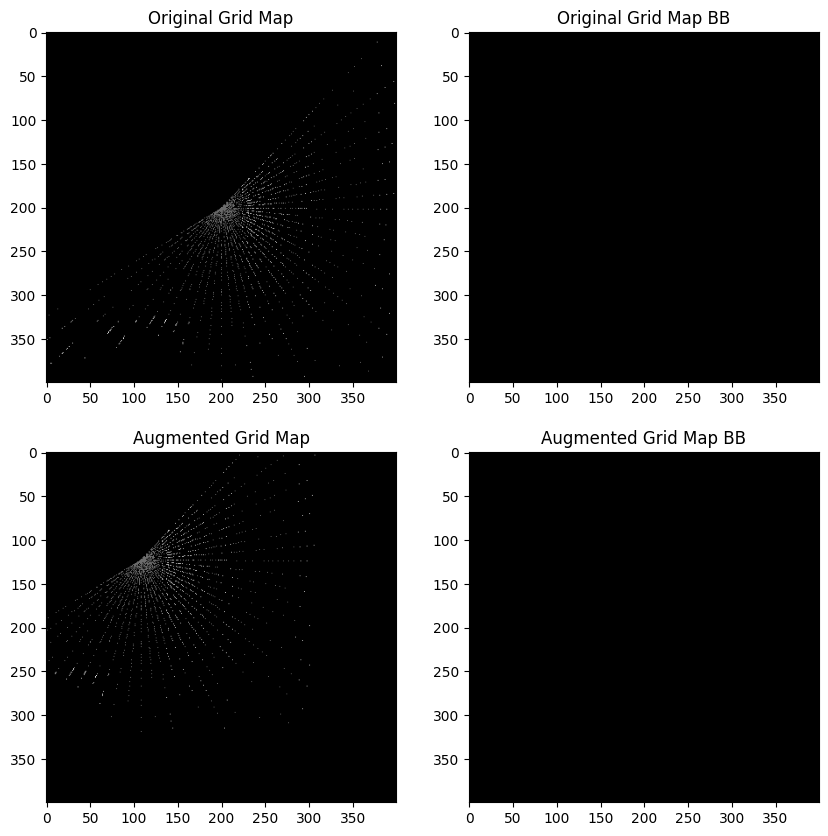

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


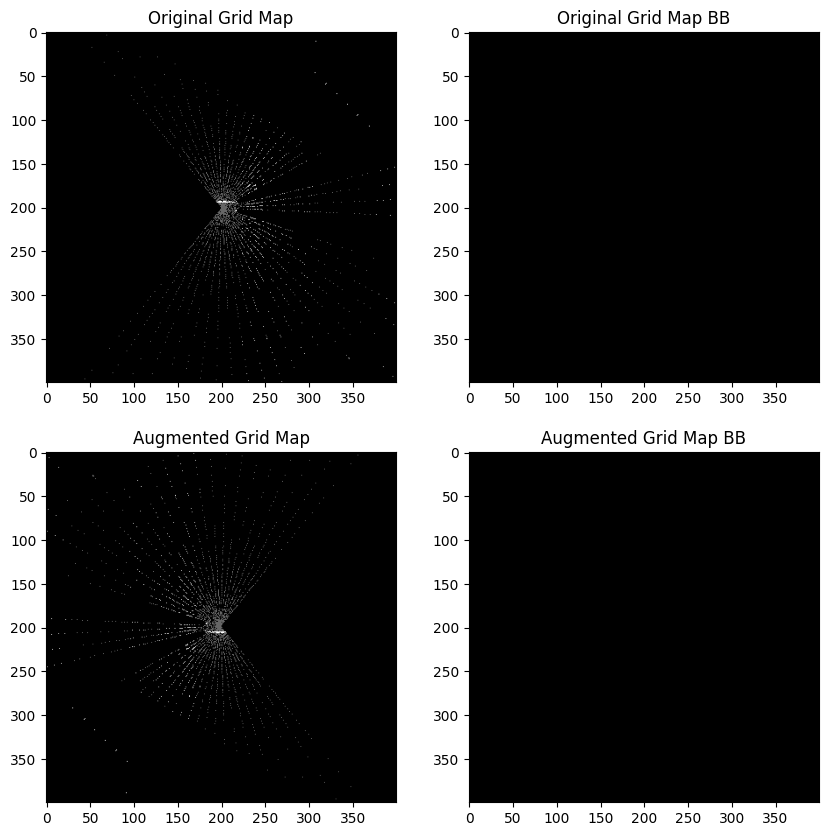

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


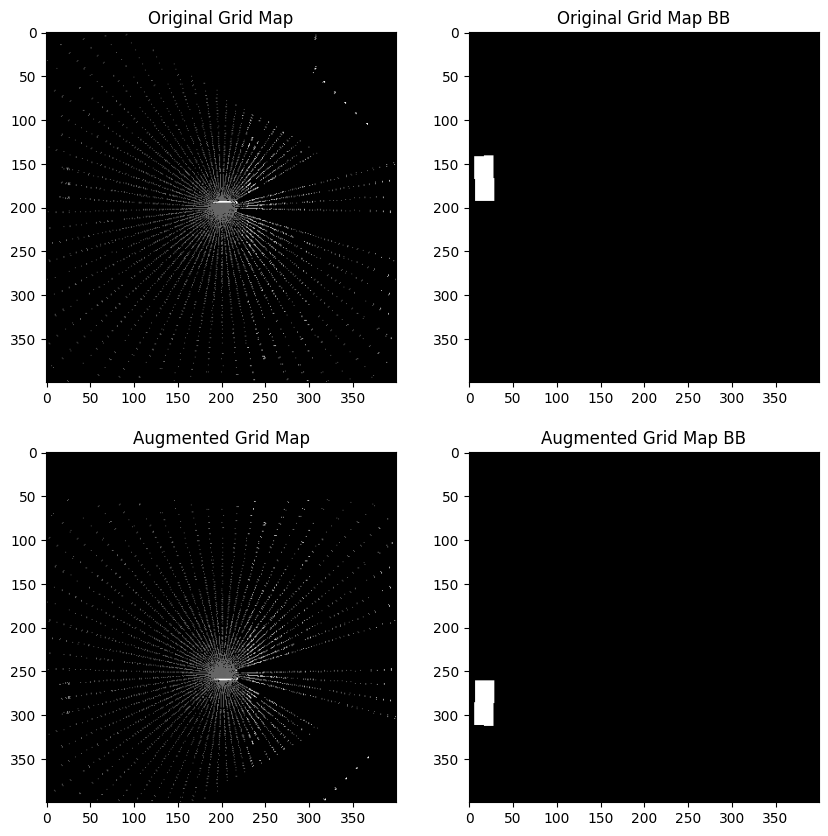

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


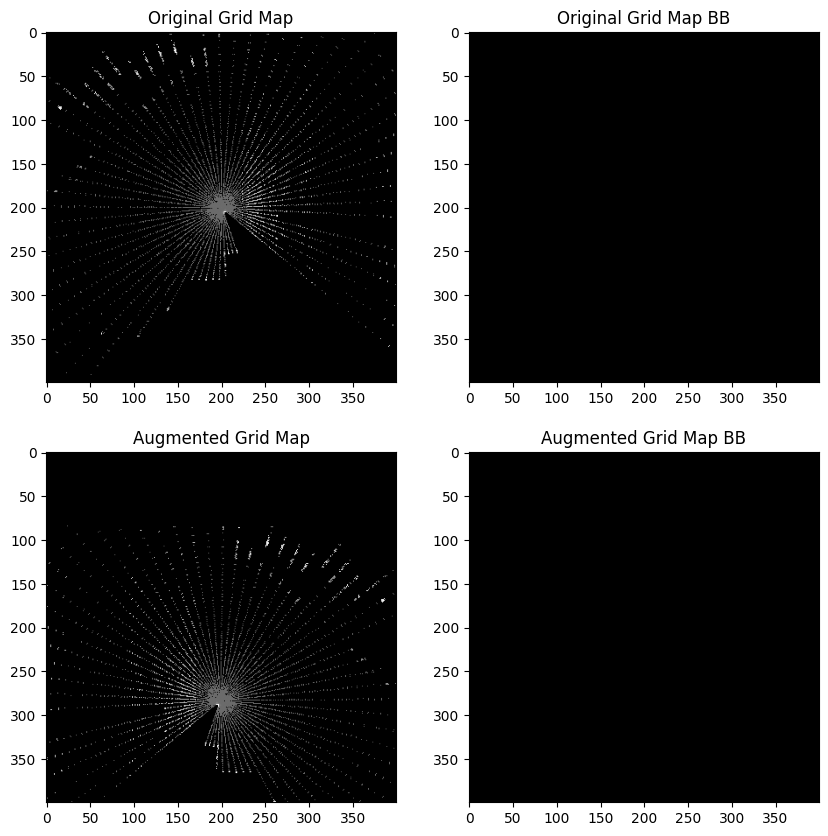

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


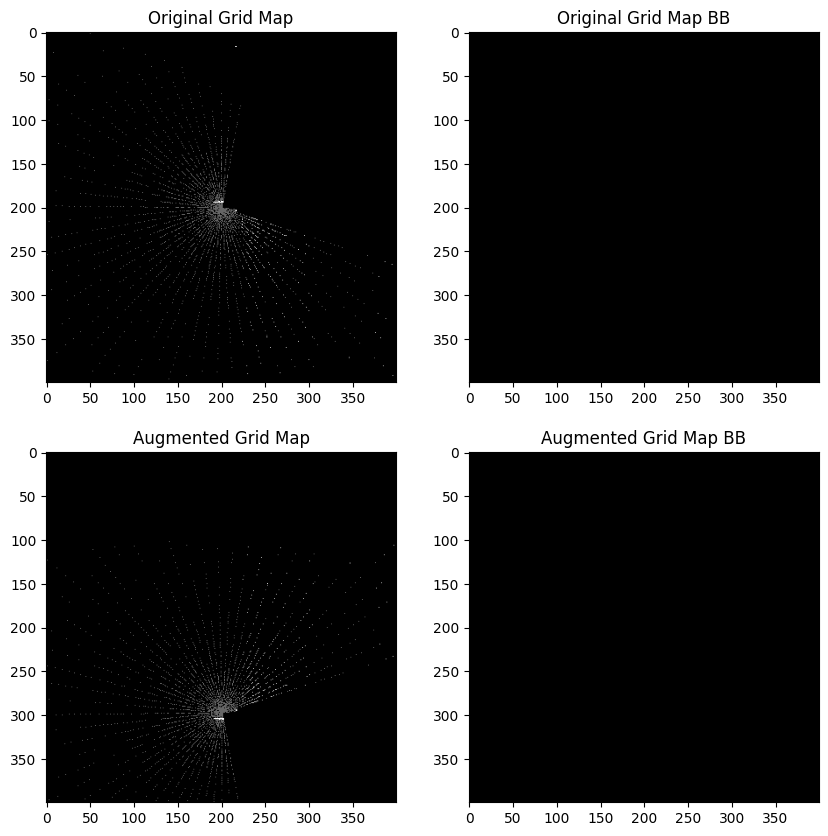

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


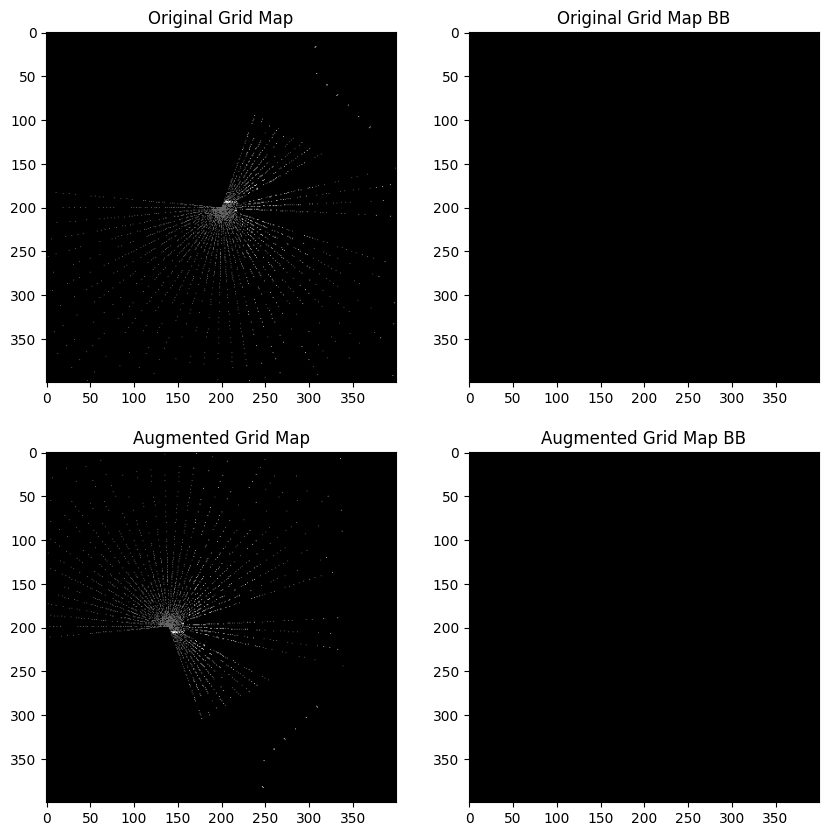

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


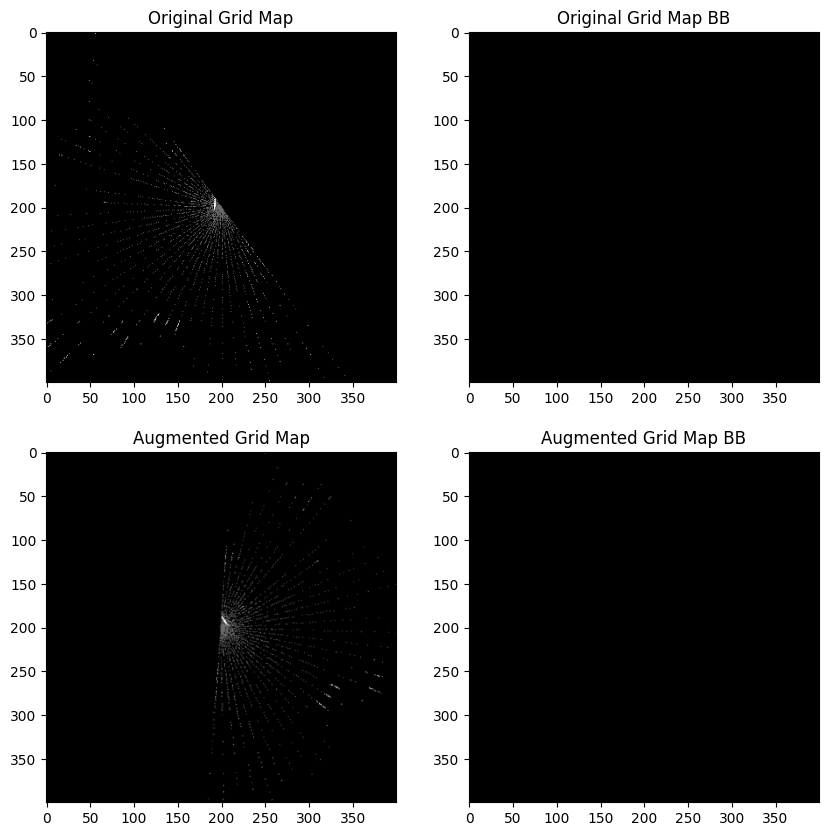

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


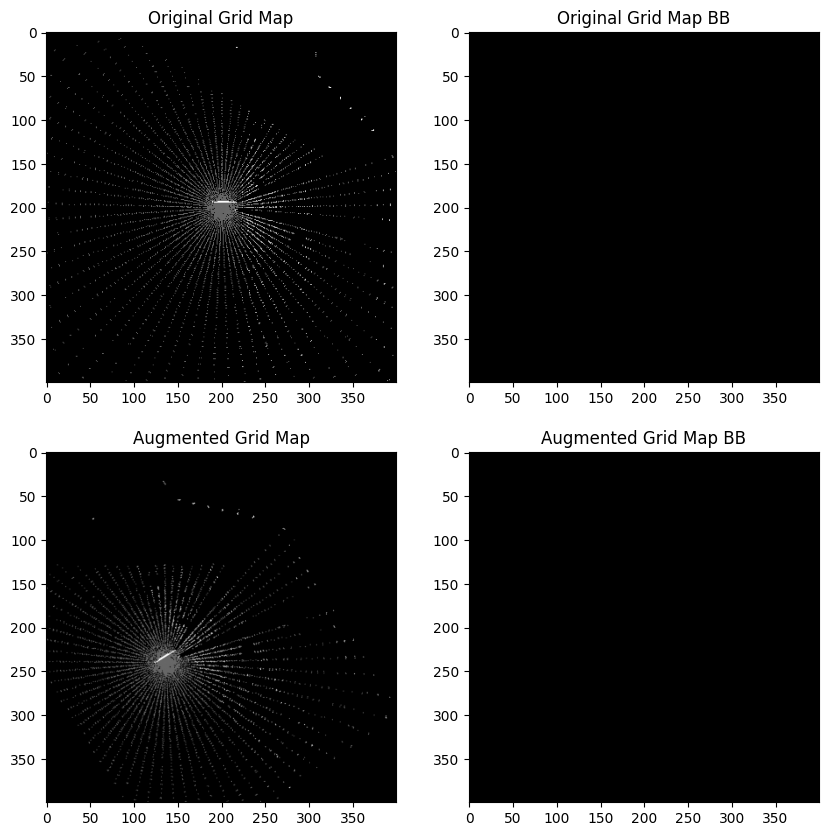

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


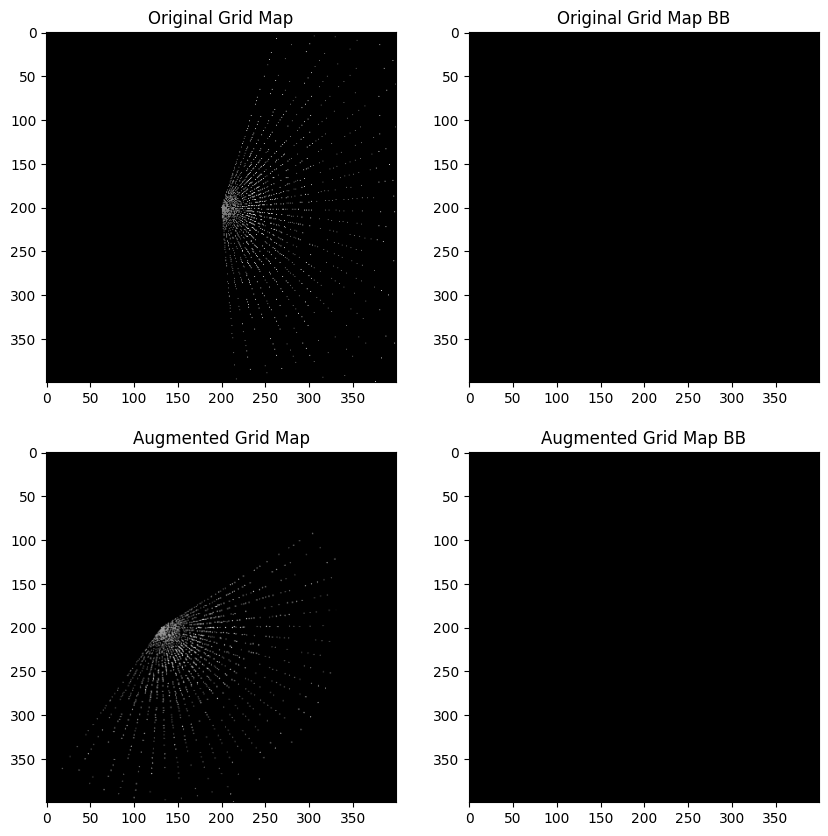

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


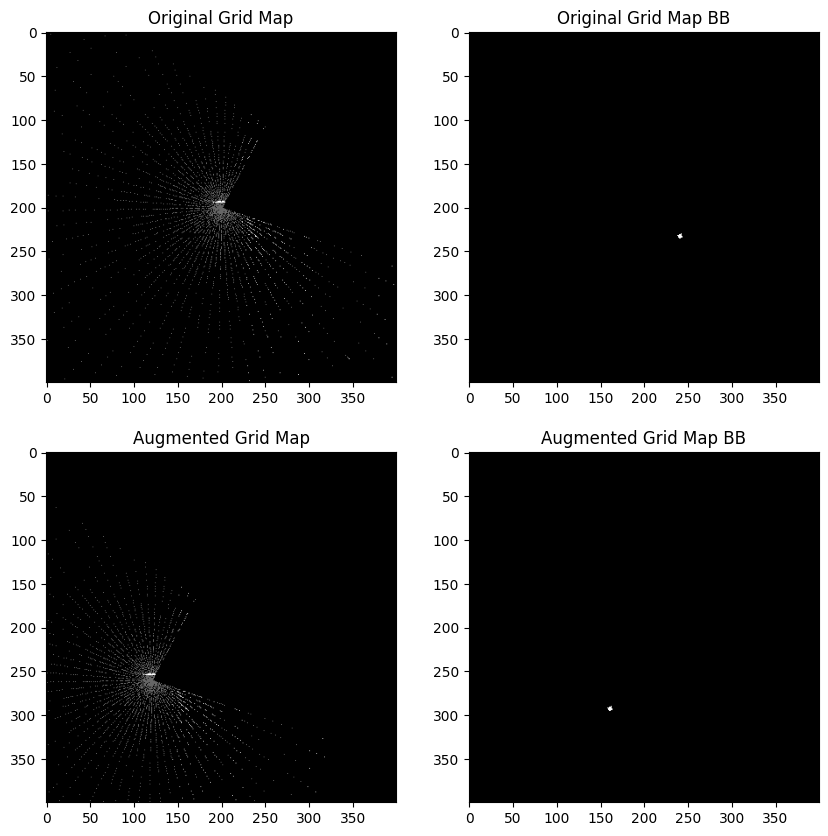

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


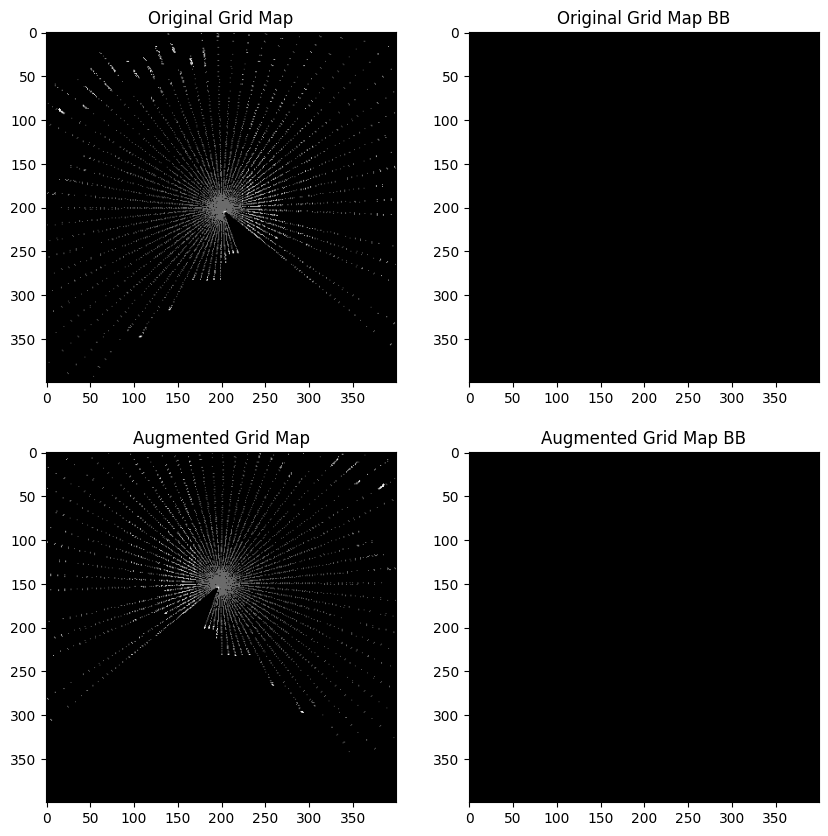

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


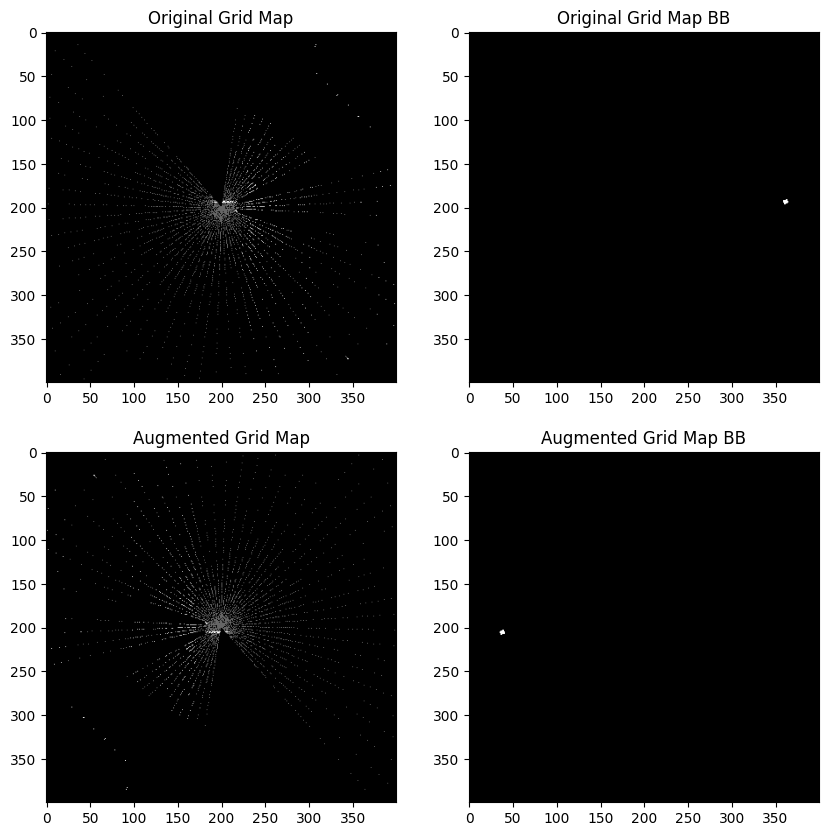

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


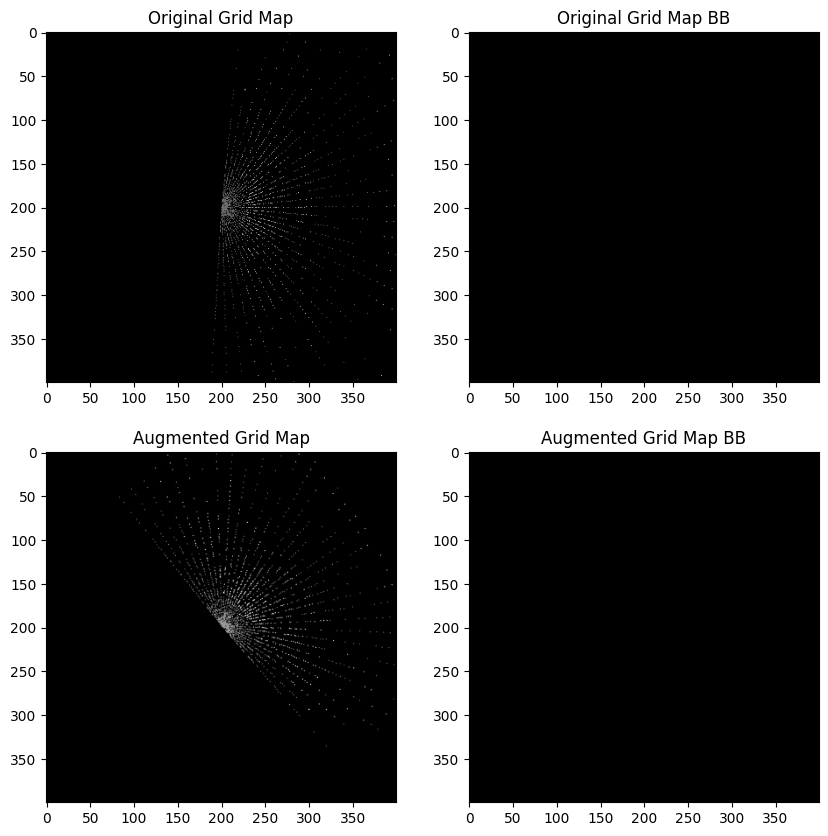

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


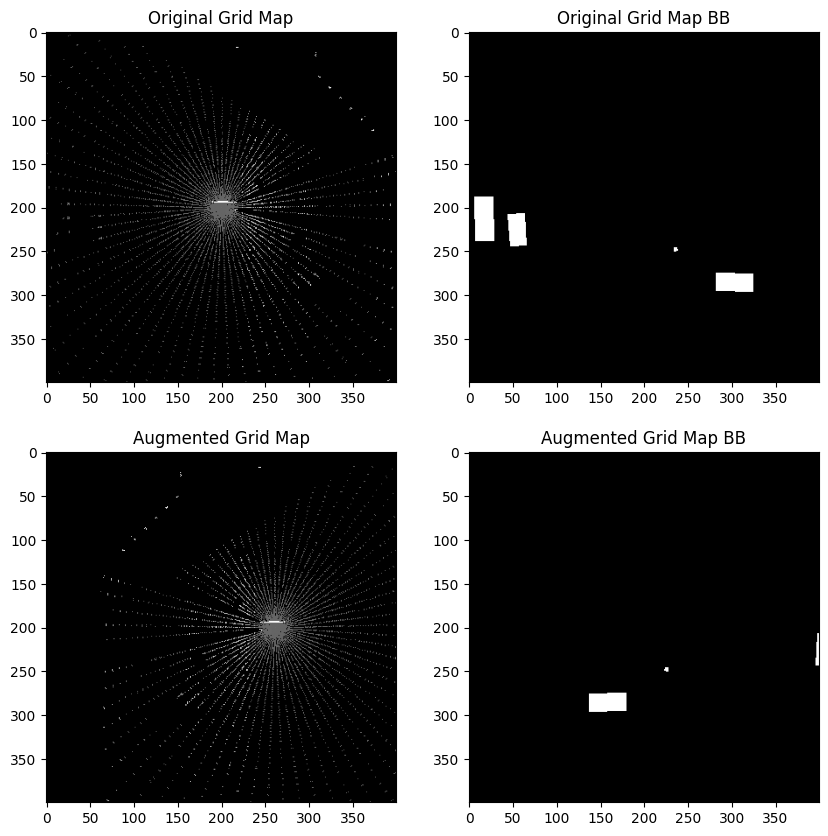

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


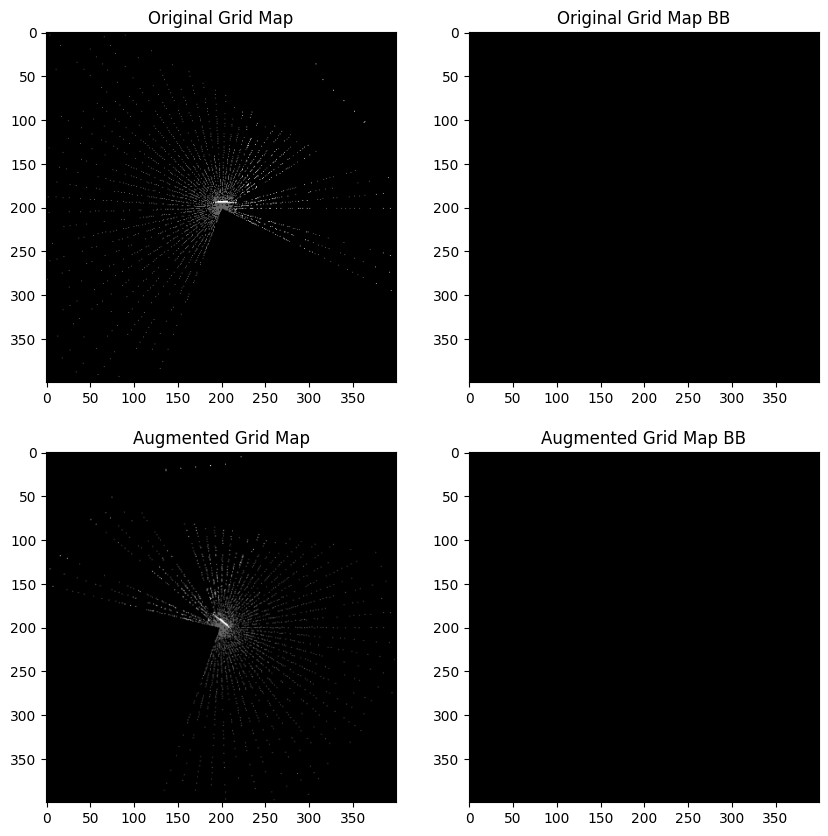

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


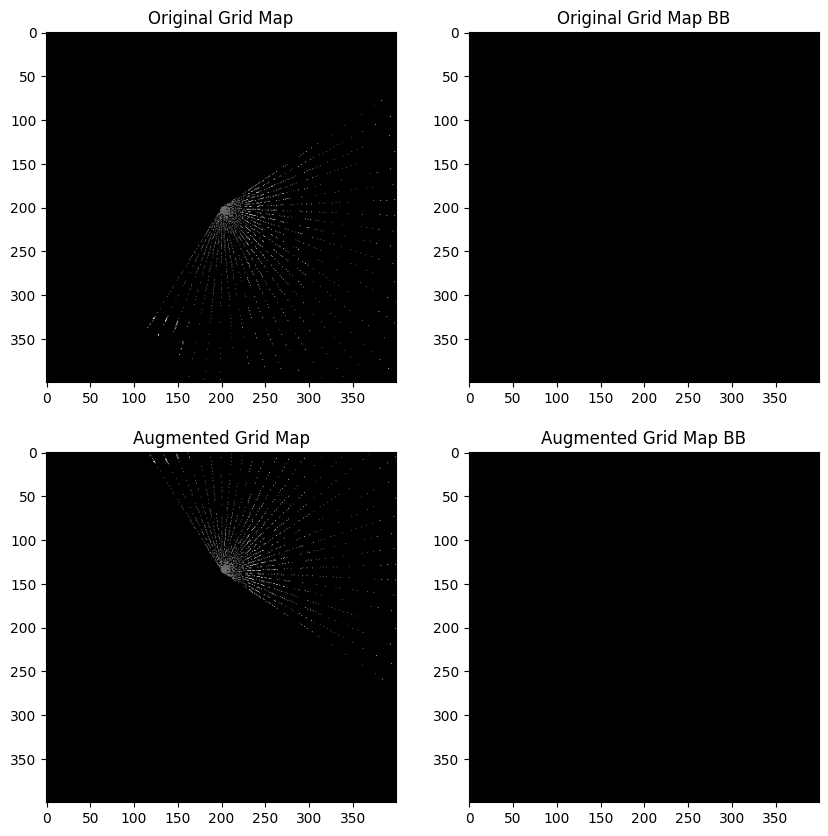

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


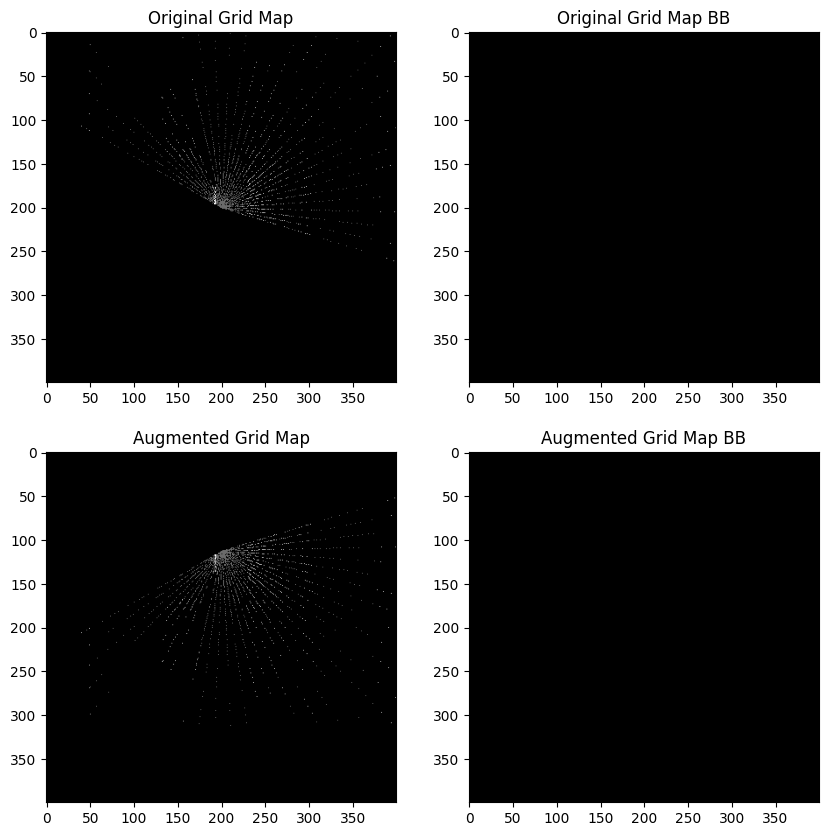

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


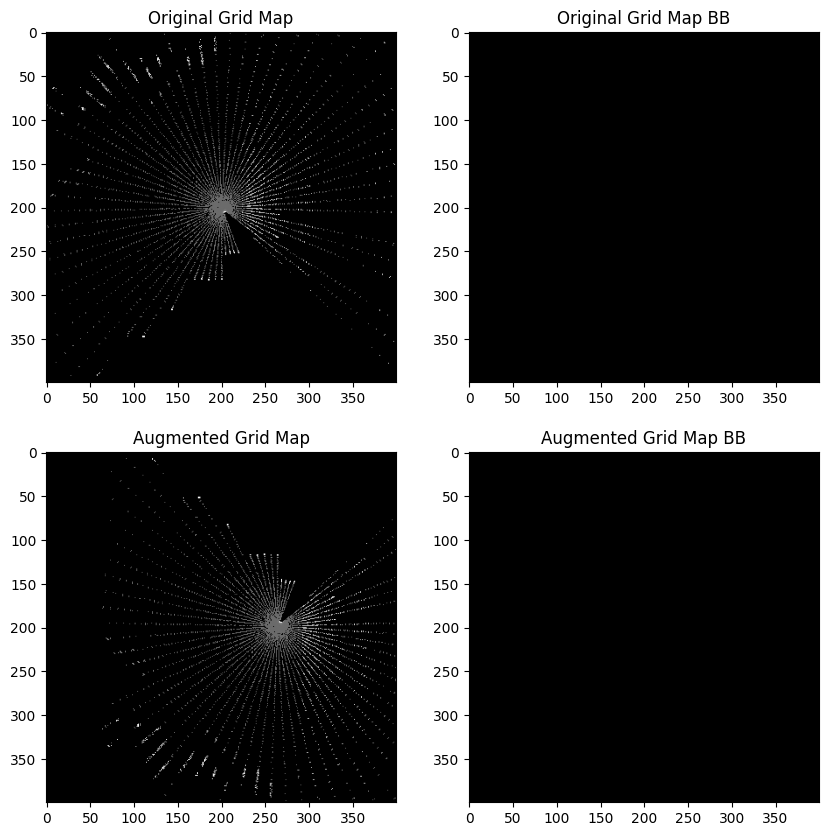

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


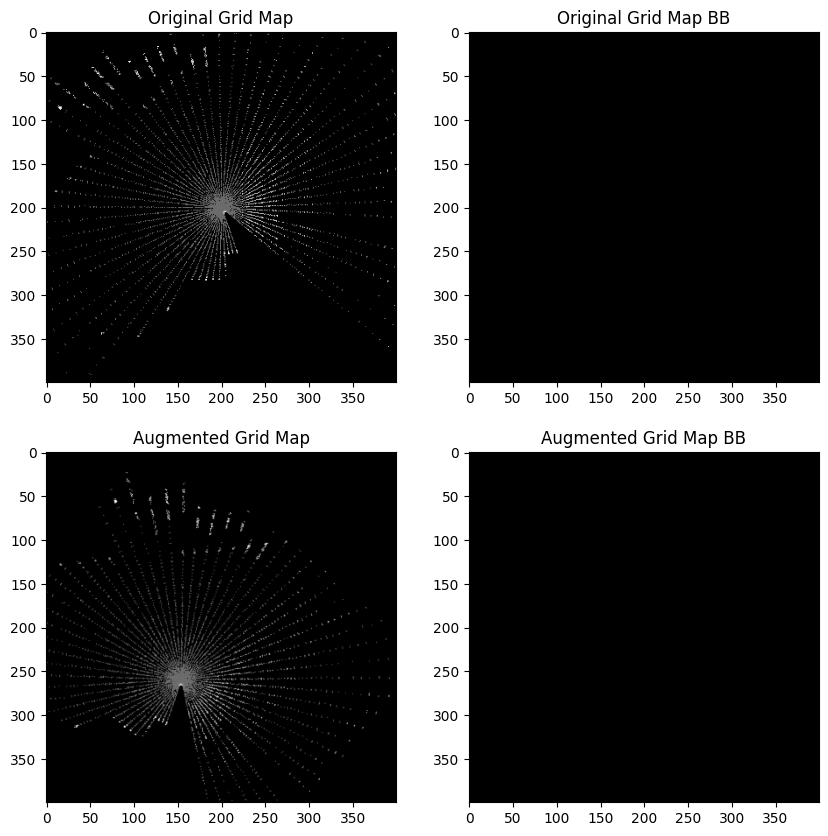

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


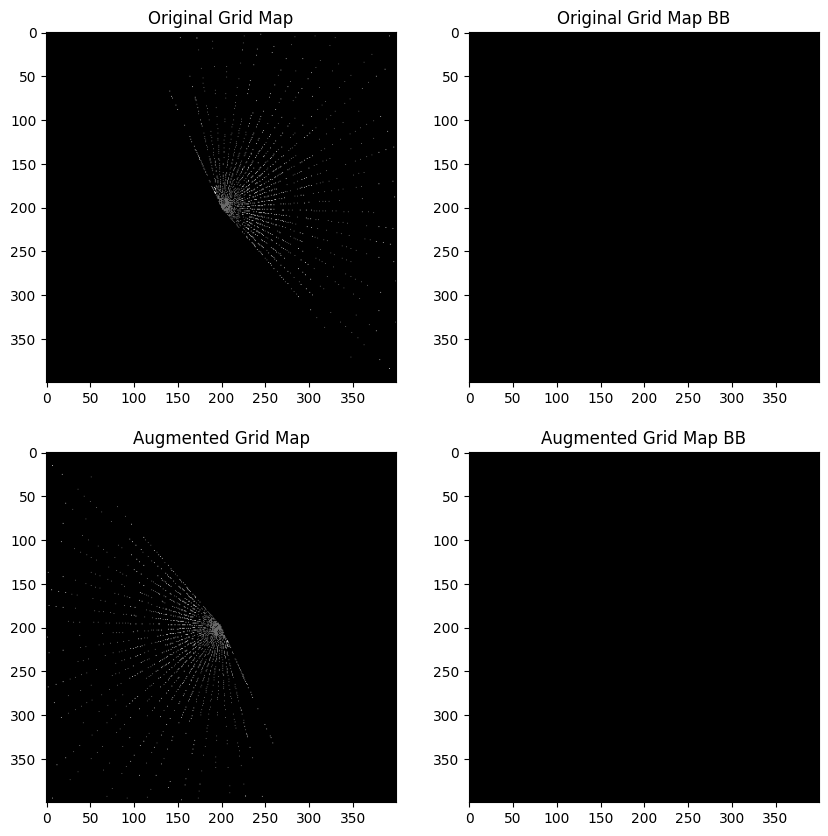

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


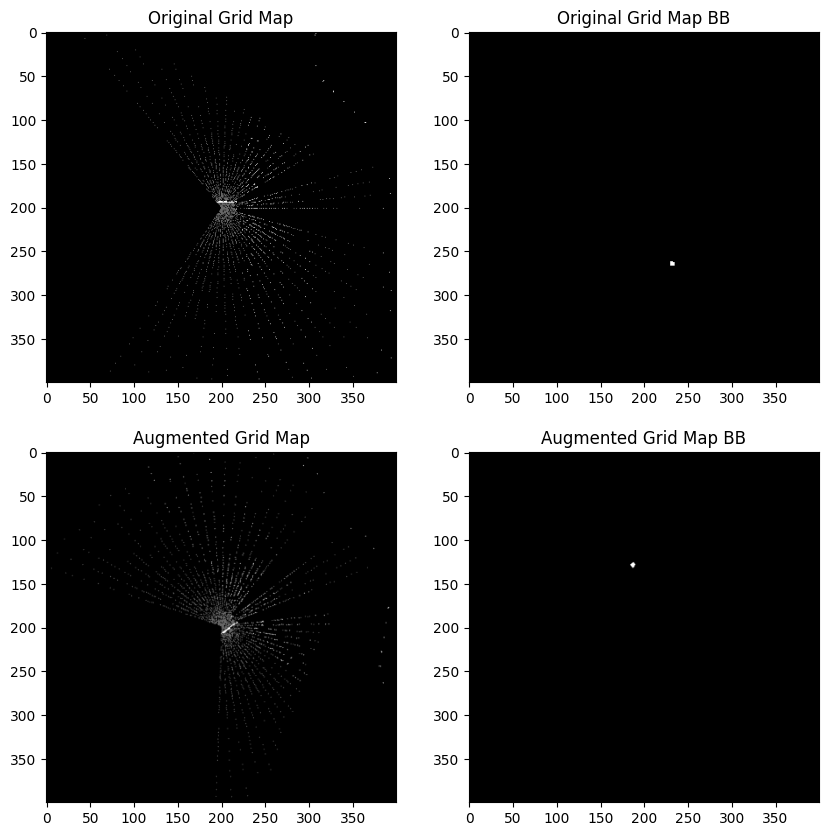

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


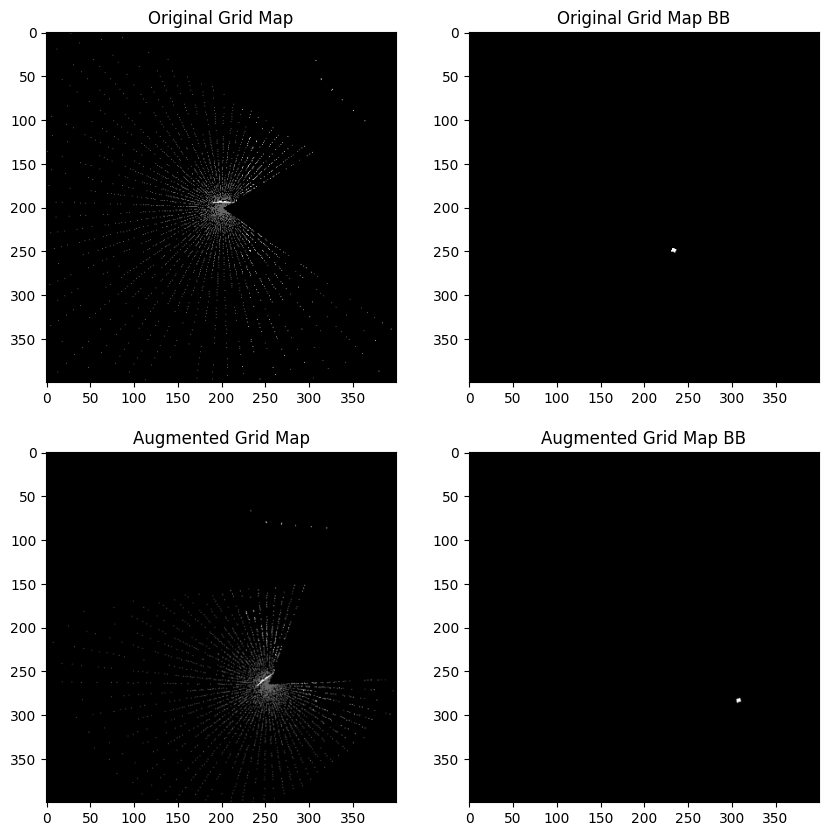

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


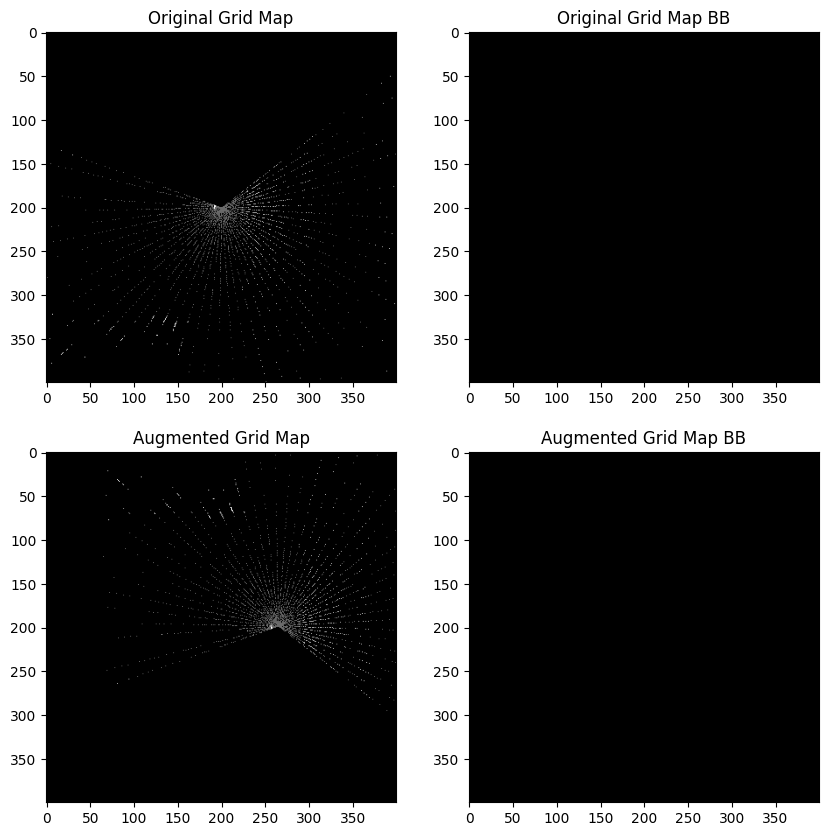

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


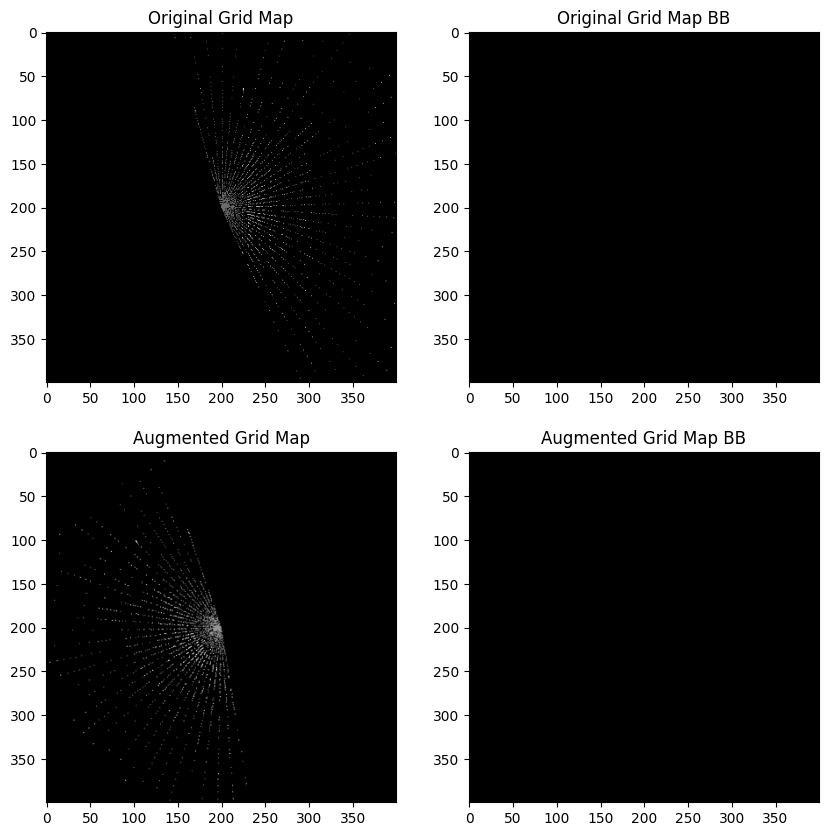

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


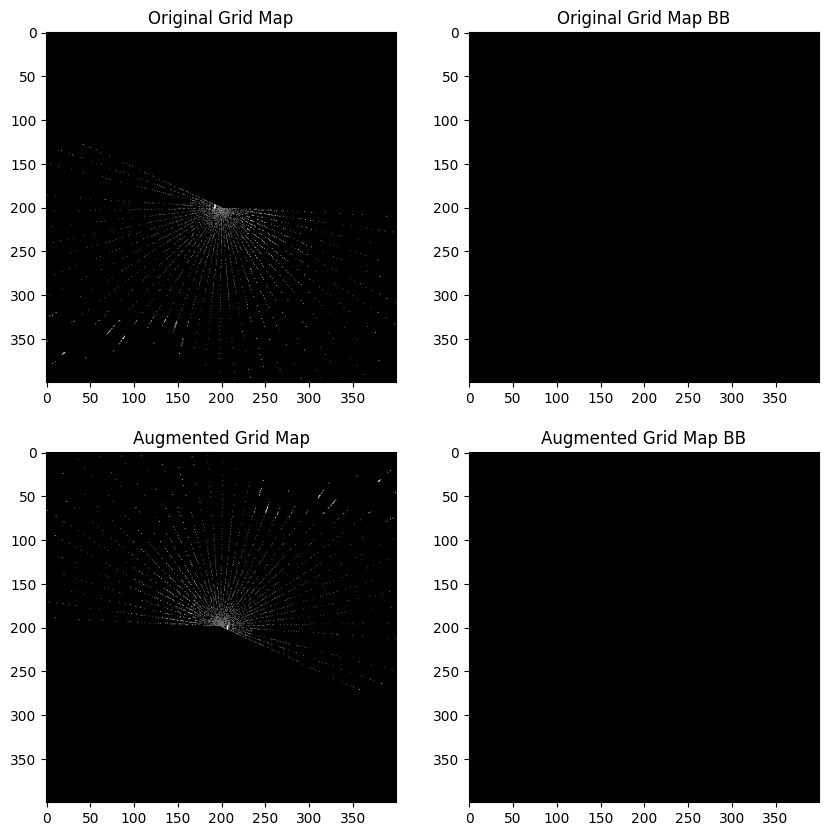

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


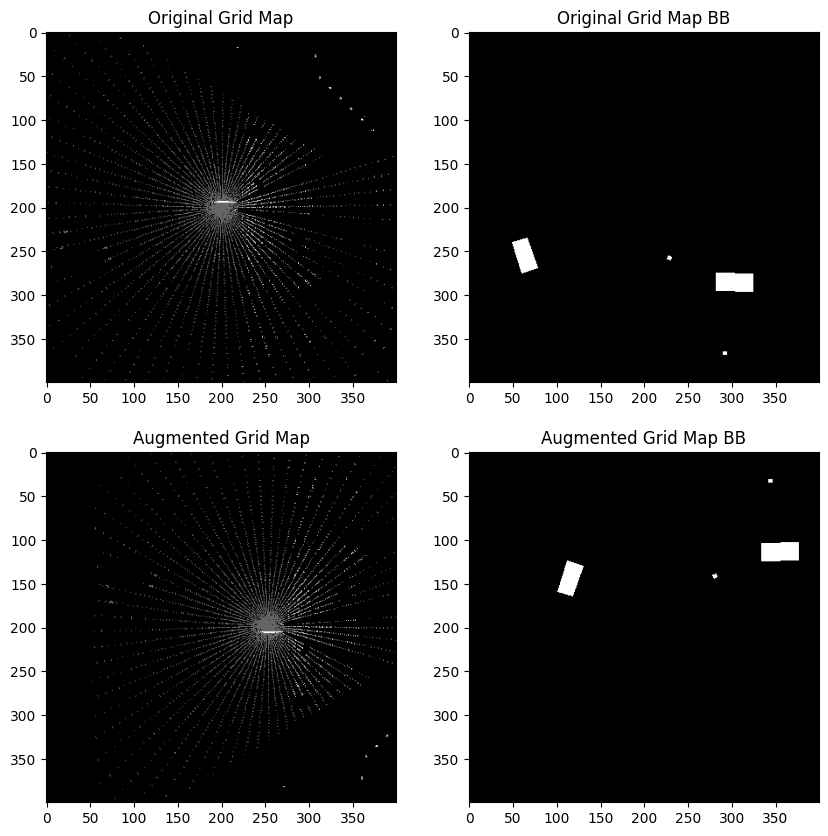

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


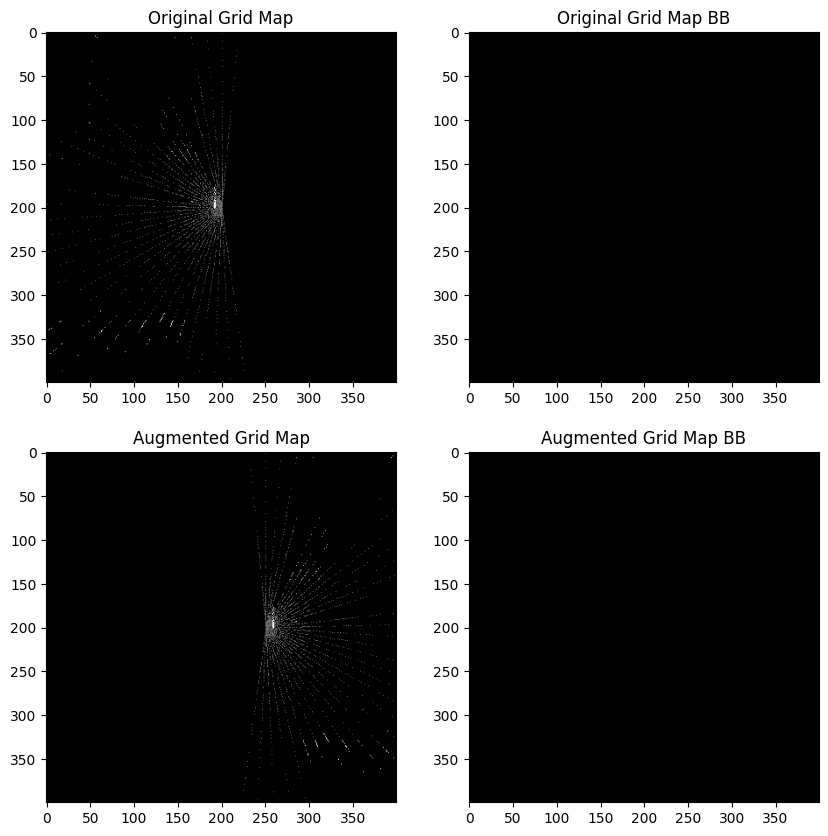

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


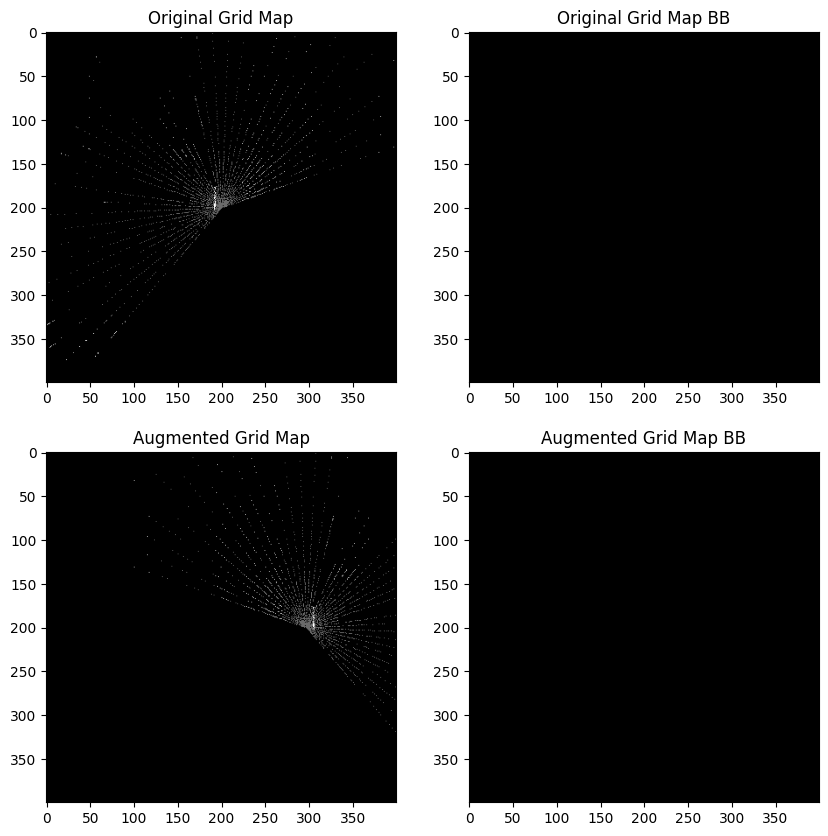

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


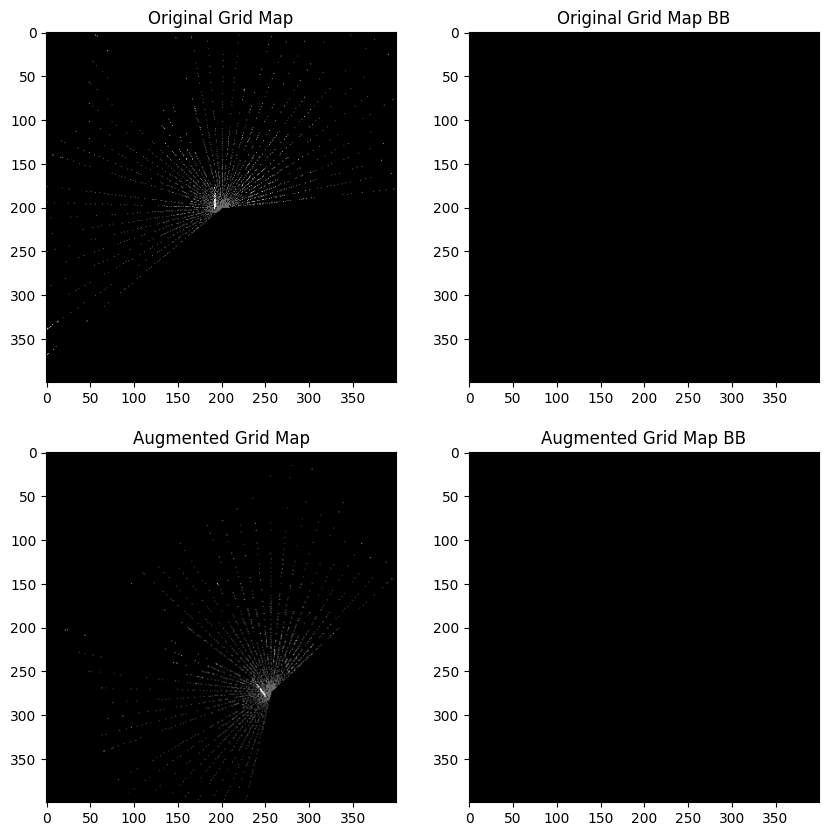

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


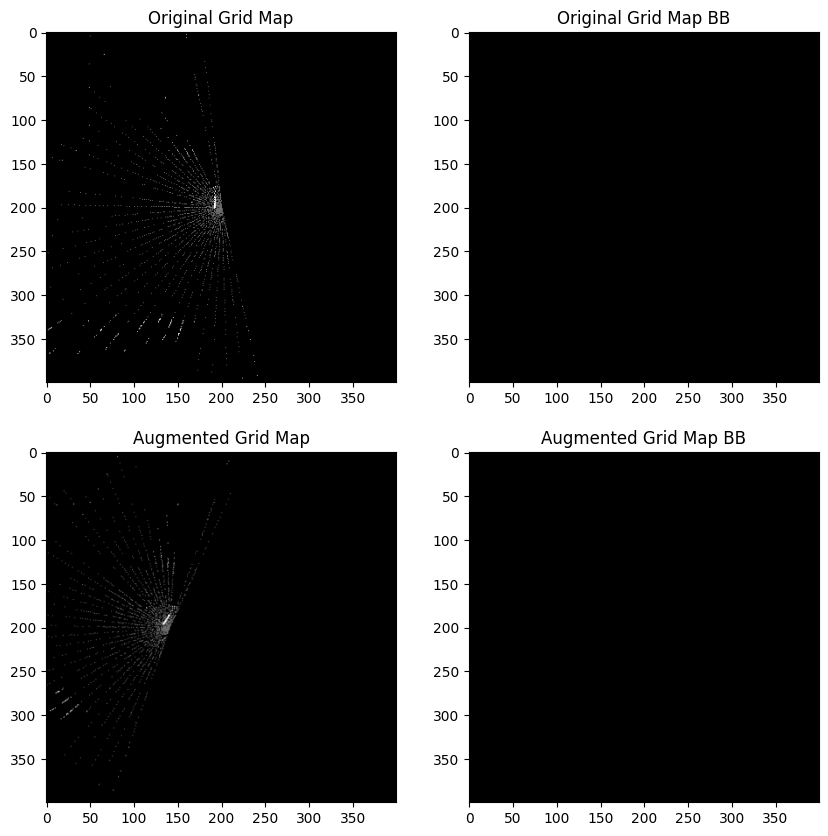

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


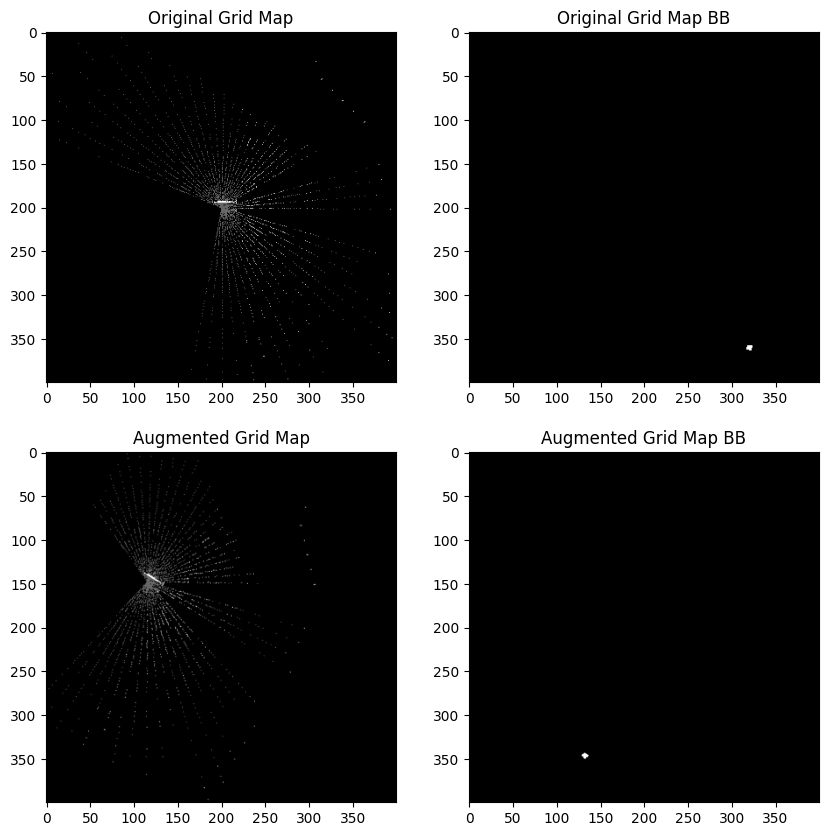

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


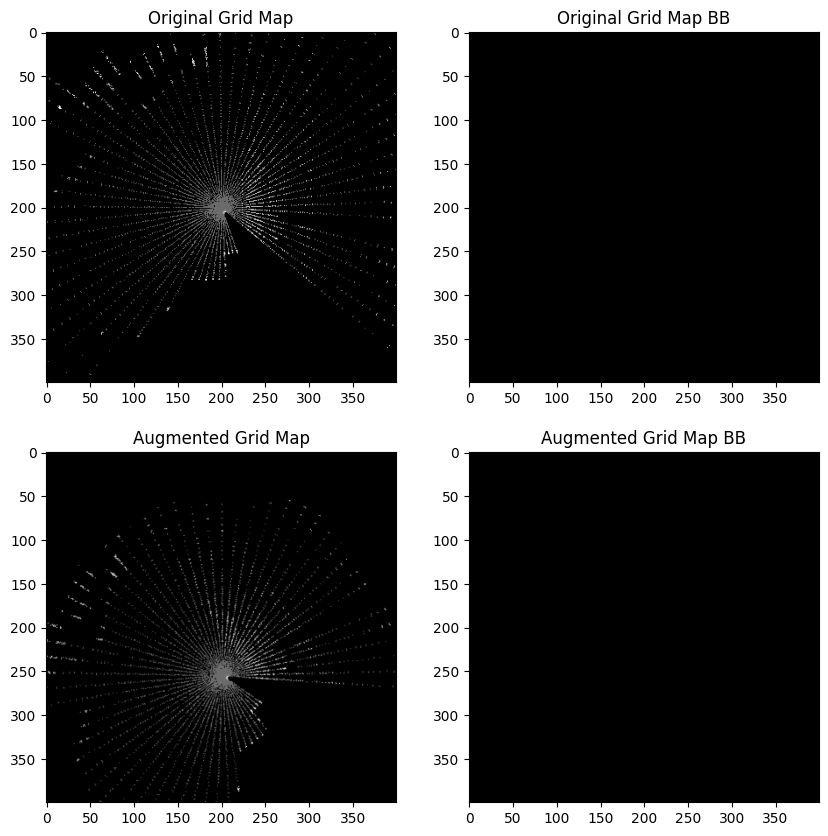

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


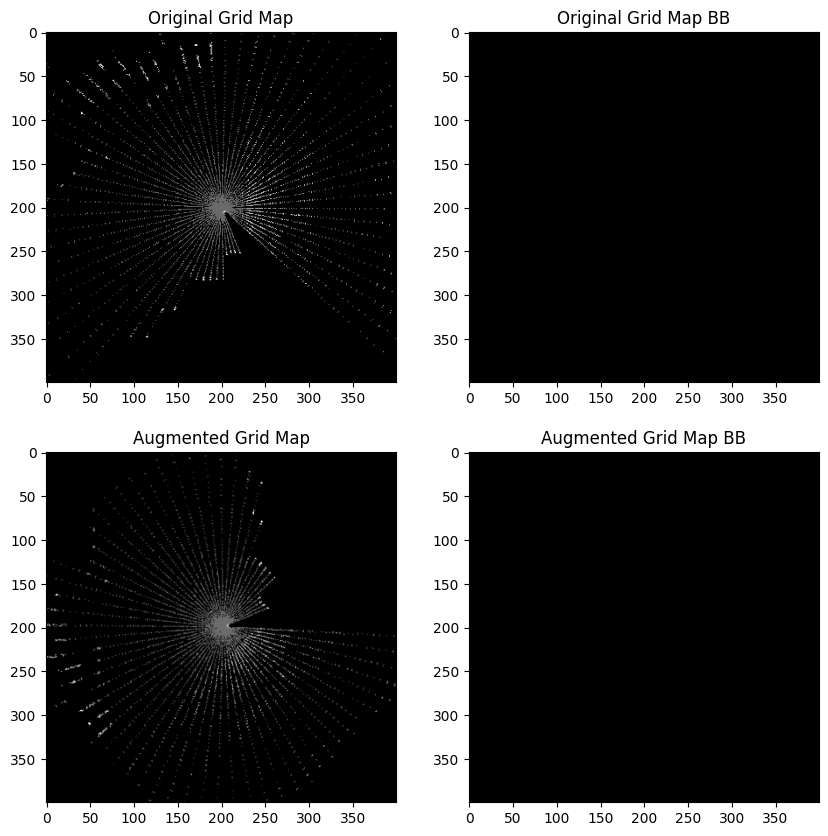

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


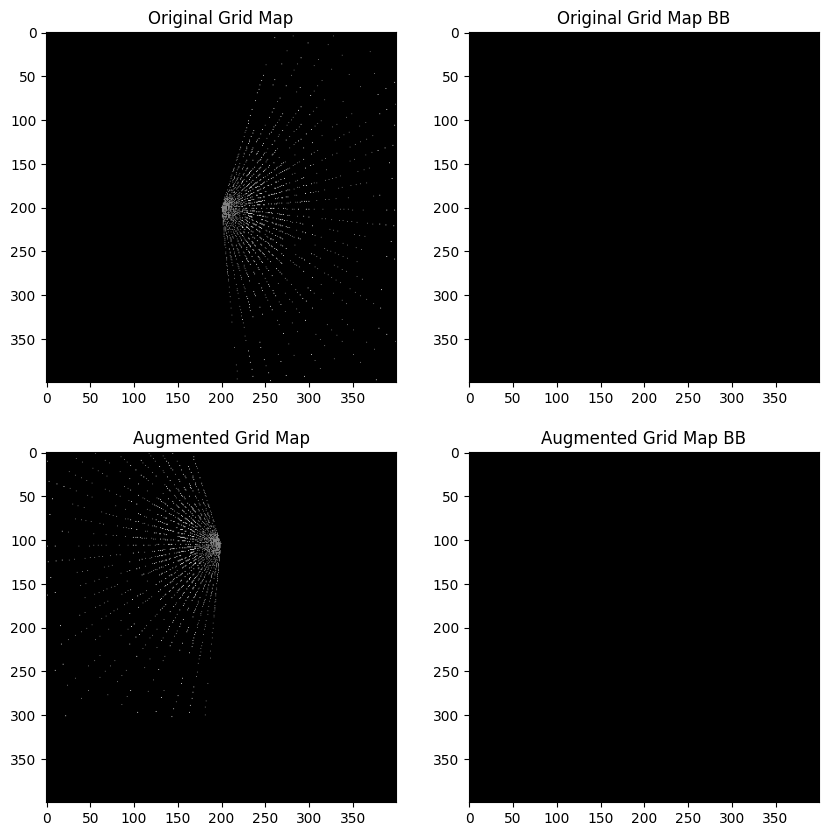

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


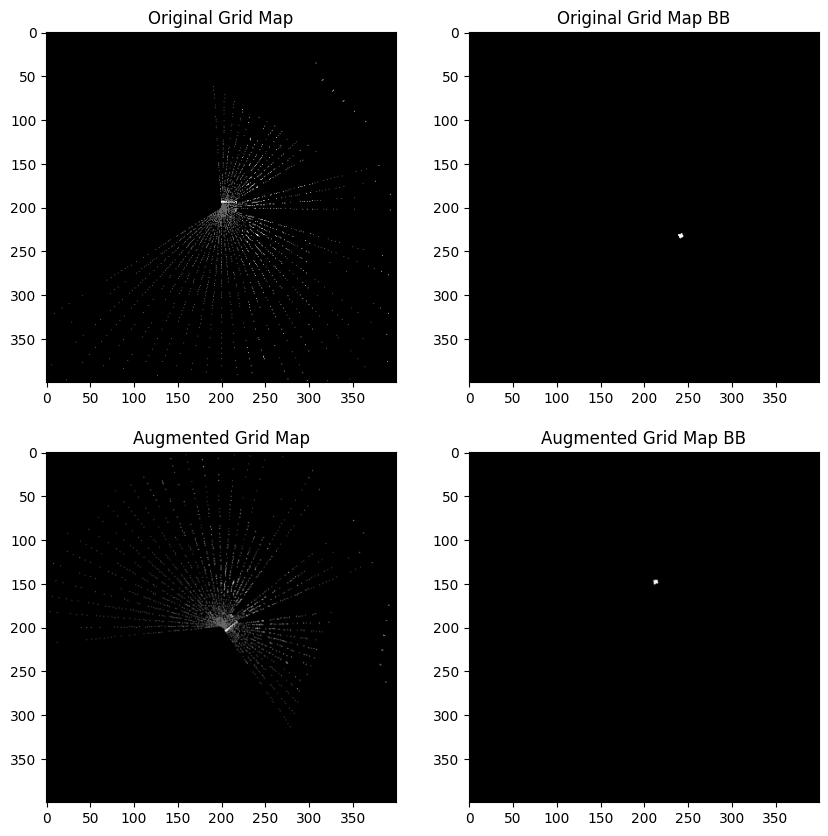

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


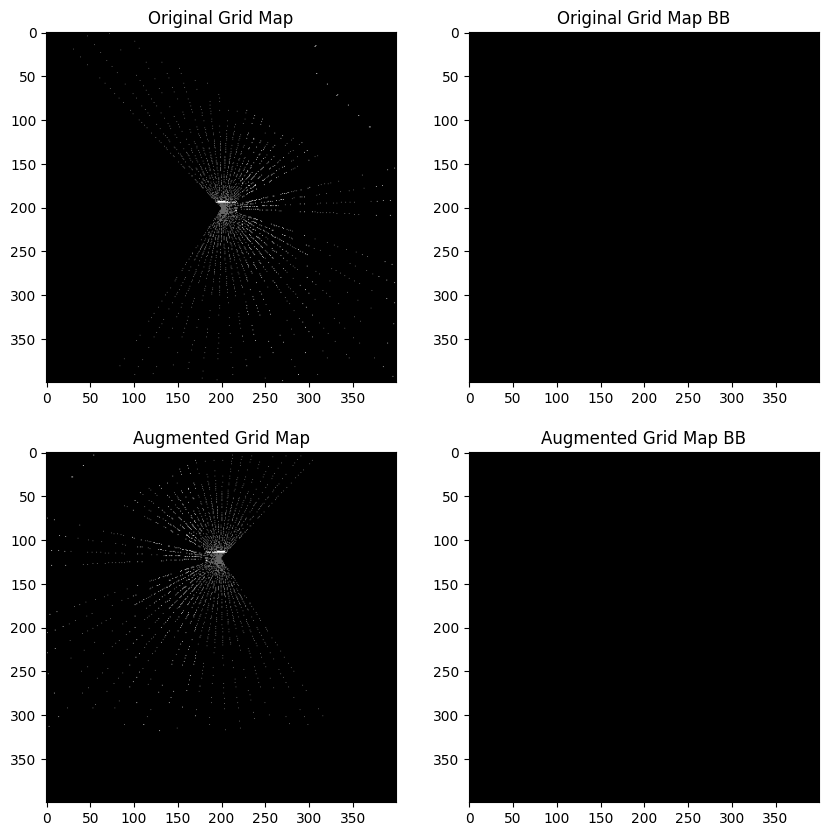

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


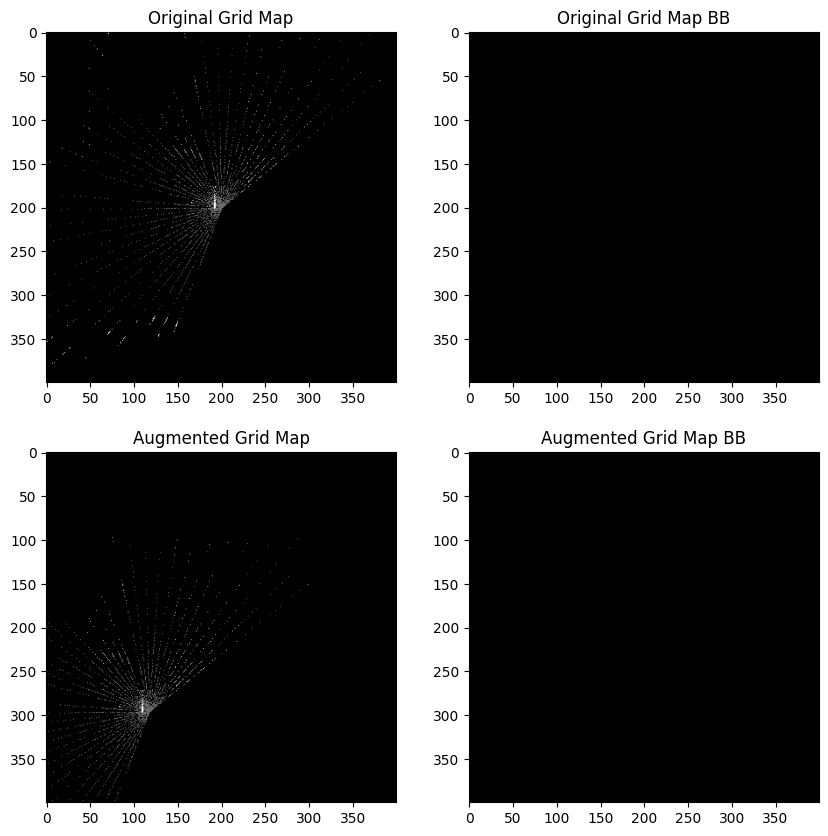

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


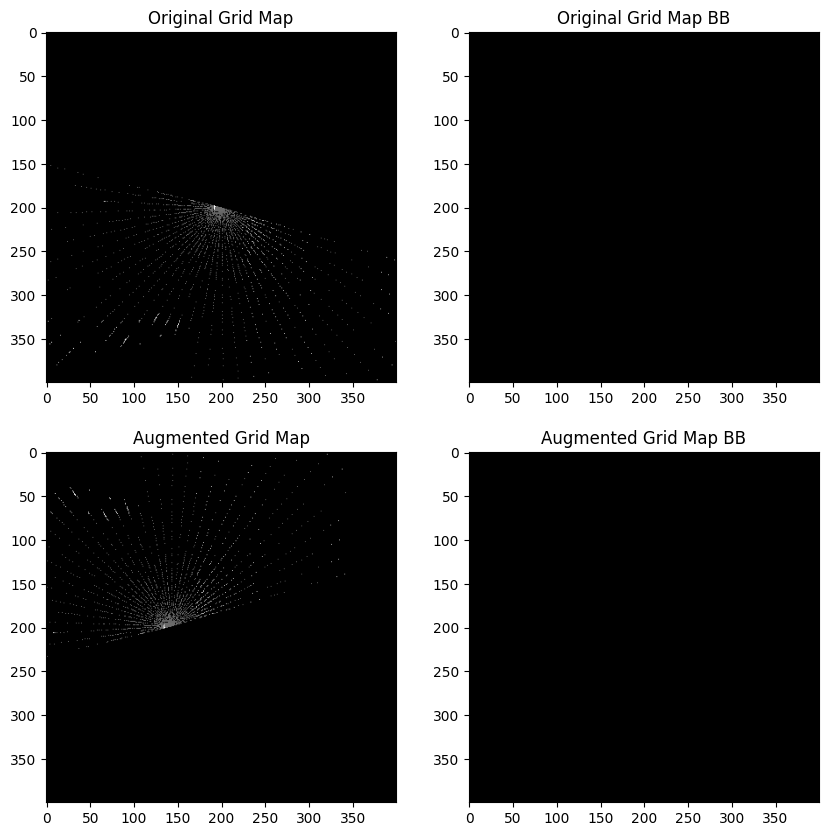

point BB original: 0.0 0.0 0.0 0.0
point BB augmented: 0.0 0.0 0.0 0.0
point original: 0.0 0.0 0.0 0.0
point augmented: 0.0 0.0 0.0 0.0


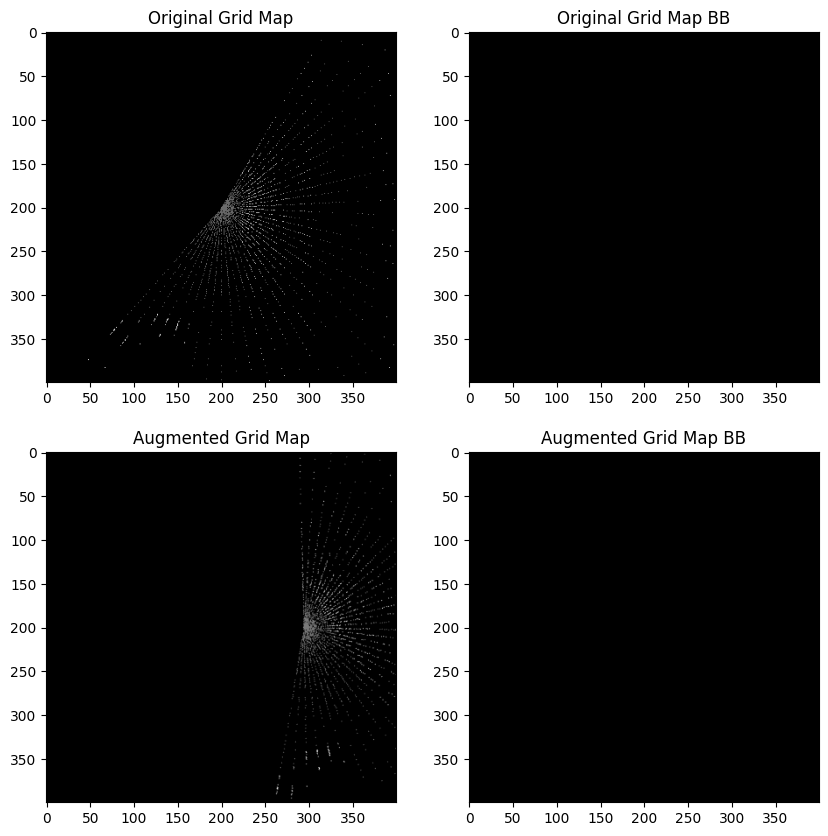

In [10]:
# Apply augmentation
augmented_grid_maps, augmented_grid_maps_BB= apply_augmentation(complete_grid_maps[0:40], complete_grid_maps_BB[0:40])
augmented_grid_maps = np.array(augmented_grid_maps)
augmented_grid_maps_BB = np.array(augmented_grid_maps_BB)

print(f"Augmented grid map shape: {augmented_grid_maps.shape}")
print(f"Augmented grid map BB shape: {augmented_grid_maps_BB.shape}")

# Visualize the original and augmented grid maps
for i in range(40):
    print("point BB original:", complete_grid_maps_BB[i][0][0], complete_grid_maps_BB[i][399][0], complete_grid_maps_BB[i][0][399], complete_grid_maps_BB[i][399][399])
    print("point BB augmented:", augmented_grid_maps_BB[i][0][0], augmented_grid_maps_BB[i][399][0], augmented_grid_maps_BB[i][0][399], augmented_grid_maps_BB[i][399][399])

    print("point original:", complete_grid_maps[i][0][0], complete_grid_maps[i][399][0], complete_grid_maps[i][0][399], complete_grid_maps[i][399][399])
    print("point augmented:", augmented_grid_maps[i][0][0], augmented_grid_maps[i][399][0], augmented_grid_maps[i][0][399], augmented_grid_maps[i][399][399])
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(complete_grid_maps[i], cmap='gray')
    ax[0, 0].set_title('Original Grid Map')
    
    ax[0, 1].imshow(complete_grid_maps_BB[i], cmap='gray')
    ax[0, 1].set_title('Original Grid Map BB')
    
    ax[1, 0].imshow(augmented_grid_maps[i], cmap='gray')
    ax[1, 0].set_title(f'Augmented Grid Map')
    
    ax[1, 1].imshow(augmented_grid_maps_BB[i], cmap='gray')
    ax[1, 1].set_title(f'Augmented Grid Map BB')
    
    plt.show()

In [11]:
# Apply augmentation
augmented_grid_maps, augmented_grid_maps_BB, augmentations = apply_augmentation(complete_grid_maps[0:5], complete_grid_maps_BB[0:5])
augmented_grid_maps = np.array(augmented_grid_maps)
augmented_grid_maps_BB = np.array(augmented_grid_maps_BB)

# Visualize the original and augmented grid maps
for i in range(5):
    print("point BB original:", complete_grid_maps_BB[i][0][0], complete_grid_maps_BB[i][399][0], complete_grid_maps_BB[i][0][399], complete_grid_maps_BB[i][399][399])
    print("point BB augmented:", augmented_grid_maps_BB[i][0][0], augmented_grid_maps_BB[i][399][0], augmented_grid_maps_BB[i][0][399], augmented_grid_maps_BB[i][399][399])

    print("point original:", complete_grid_maps[i][0][0], complete_grid_maps[i][399][0], complete_grid_maps[i][0][399], complete_grid_maps[i][399][399])
    print("point augmented:", augmented_grid_maps[i][0][0], augmented_grid_maps[i][399][0], augmented_grid_maps[i][0][399], augmented_grid_maps[i][399][399])
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(complete_grid_maps[i], cmap='gray')
    ax[0, 0].set_title('Original Grid Map')
    
    ax[0, 1].imshow(complete_grid_maps_BB[i], cmap='gray')
    ax[0, 1].set_title('Original Grid Map BB')
    
    ax[1, 0].imshow(augmented_grid_maps[i], cmap='gray')
    ax[1, 0].set_title(f'Augmented Grid Map with {augmentations[i]}')
    
    ax[1, 1].imshow(augmented_grid_maps_BB[i], cmap='gray')
    ax[1, 1].set_title(f'Augmented Grid Map BB with {augmentations[i]}')
    
    plt.show()

ValueError: not enough values to unpack (expected 3, got 2)